# SCC-ICMC-USP - 1o. semestre de 2024

## SCC5871/MAI5025 - Exercício 3

## Profa. Roseli A. F. Romero


Nro do grupo: - 

Alunos:

1.   João Francisco Baiochi (n.ºUSP 7547674)
2.   

---  

## Objetivo: Curva ROC e Teste de hipótese; Utilização de Perceptron, MLP, DT e KNN

## Funções novas utilizadas no exercício

- `pandas.Series.nunique()` ([link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.nunique.html)): Conta quantidade de valores únicos de uma coluna. Útil para verificar se uma coluna é relevante ou não
- `scipy.stats.ttest_ind()` ([link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind)): Calcula o teste t para duas amostras independentes
- `sklearn.metrics.plot_roc_curve()` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html)): Plota a curva ROC de um classificador dado um conjunto de input e alvo

### Questão 01.

Faça a exploração dos dados. Isto é, carregue, substitua valores faltantes, padronize os dados, etc. Faça também a seleção dos atributos que achar mais relevantes.

 - Dica: Utilize a função `nunique()` durante a exploração dos dados. Você pode utilizar o "bom senso" (além de outras ferramentas é claro) na hora de escolher qual atributo do conjunto manter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import numerical_plot, categorical_plot

sns.set()

df = pd.read_csv("../data/titanic.csv")
df['Survived'] = df['Survived'].astype(bool)
df['Pclass'] = df['Pclass'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    bool    
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    object  
dtypes: bool(1), category(1), float64(2), int64(3), object(5)
memory usage: 71.6+ KB


In [2]:
print('Verificando a quantidade de valores em cada coluna com o método nunique():')

display(df.nunique())

Verificando a quantidade de valores em cada coluna com o método nunique():


PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

A partir dessas observações, identificamos potenciais colunas que não agregam informação ao modelo por conter apenas valores únicos ou identificadores únicos para cada passageiro: `'PassengerId'`, `'Name1`, `'Ticket1` e `'Cabin1`. Entretando, antes de remover, é possível extrair informações mais úteis da feature `Cabin`:

In [3]:
print('Extraindo apenas a label do convés do passageiro:')
df['Deck'] = df['Cabin'].dropna().str[0]
display(df['Deck'].value_counts())

# Removendo as colunas originais
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

Extraindo apenas a label do convés do passageiro:


Deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64

Agora iremos visualizar as distribuições de cada feature para o dataset filtrado:

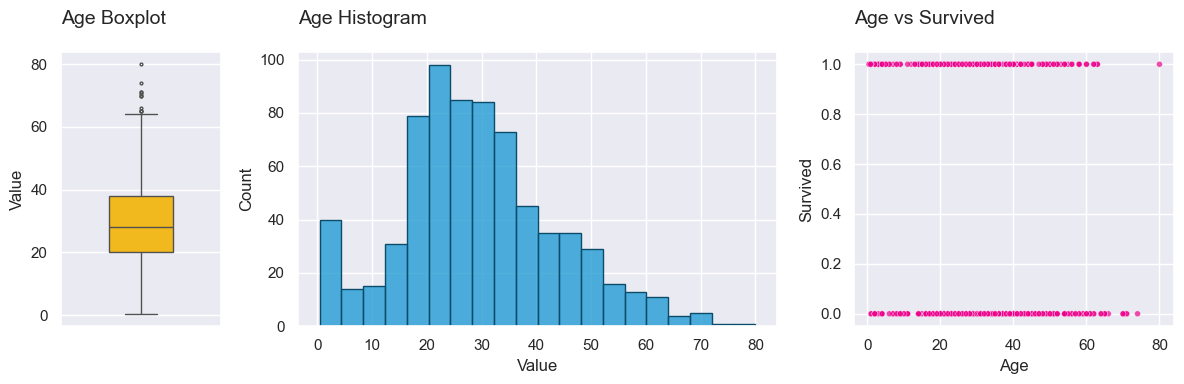

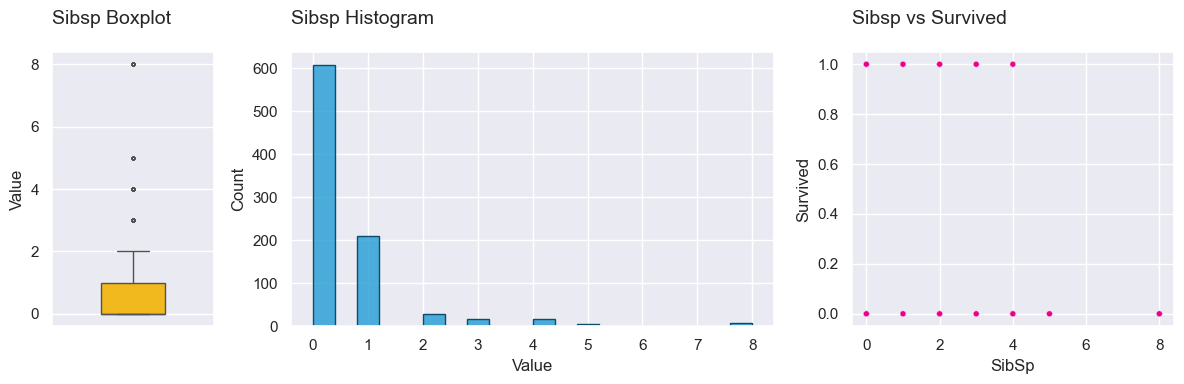

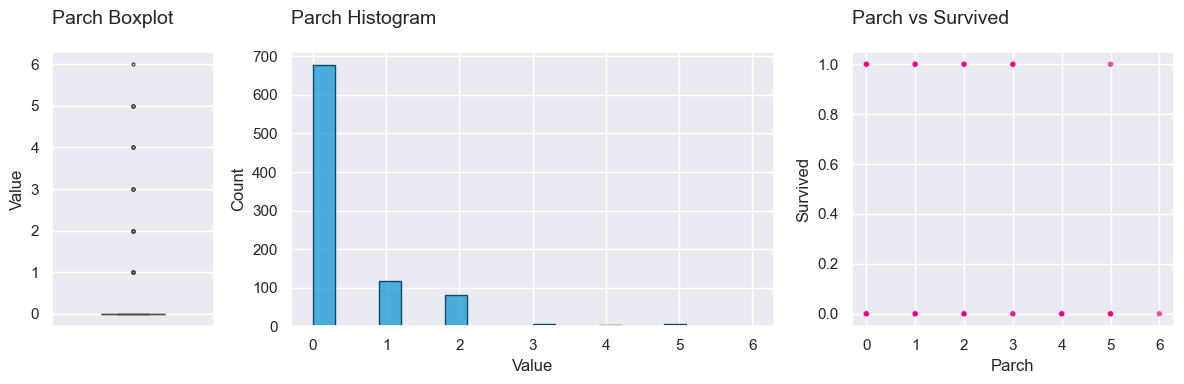

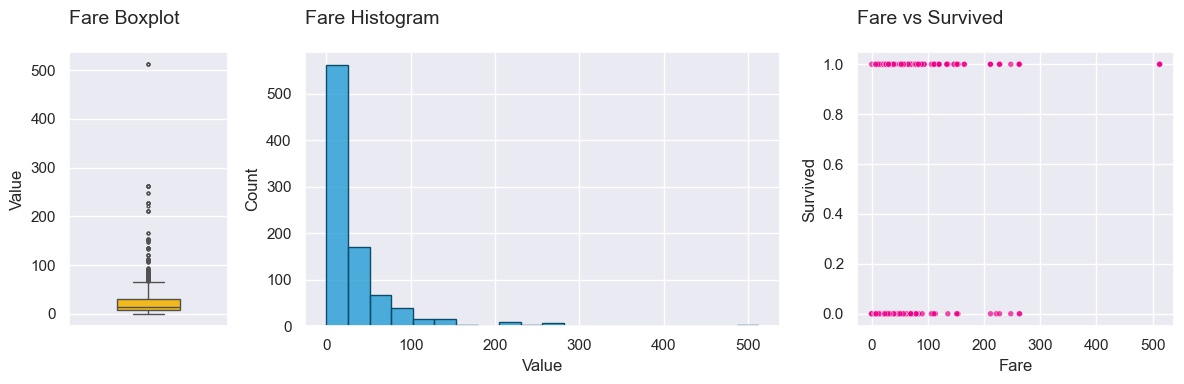

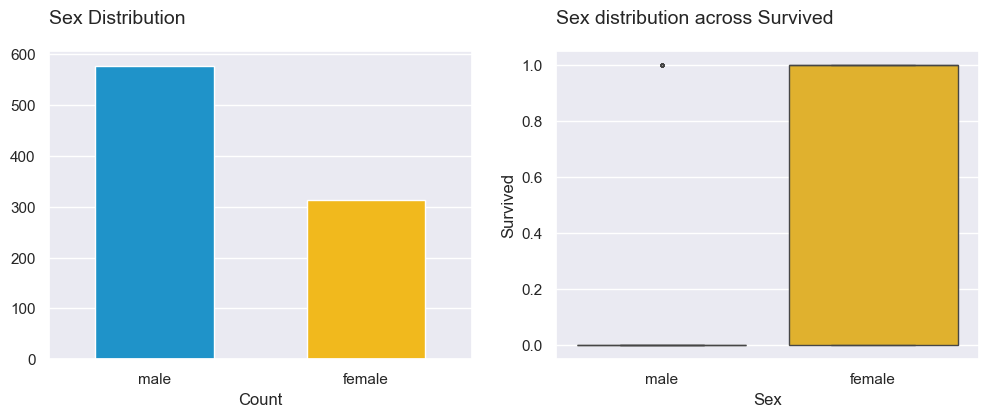

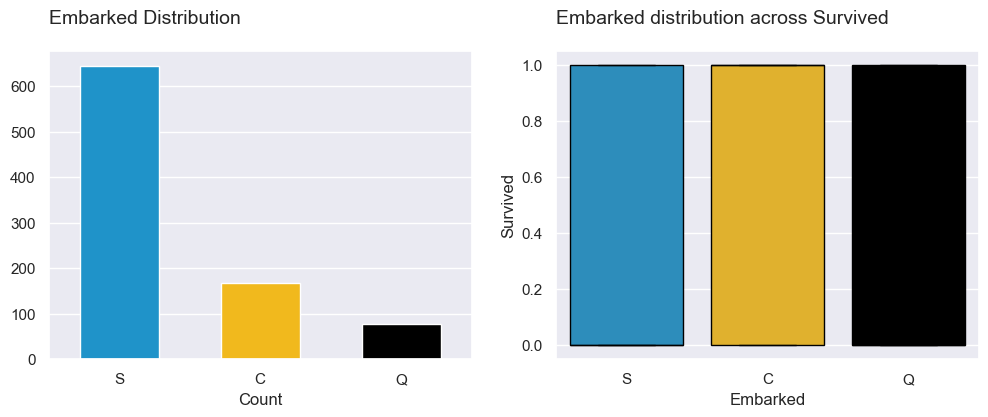

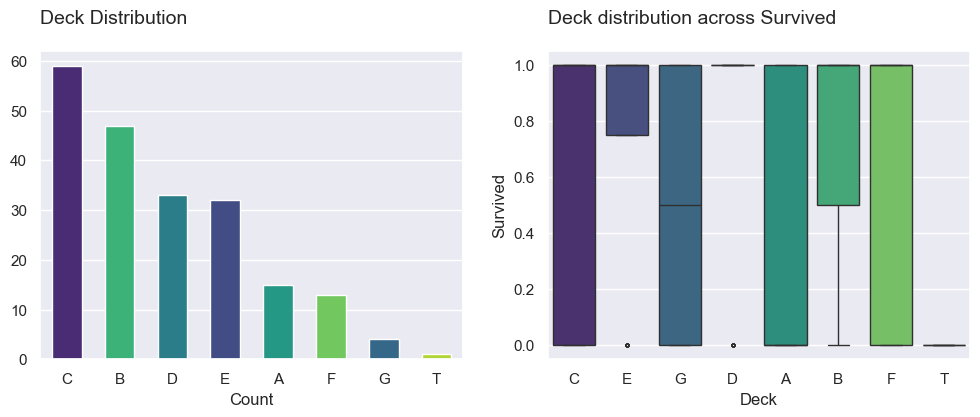

In [4]:
# Definindo o target do problema de classificação
target = 'Survived'

# Visualizando as features numéricas
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    numerical_plot(df, col, target)

# Visualizando as features categóricas
for col in df.select_dtypes(include='object').columns:
    categorical_plot(df, col, target)

In [5]:
# Etapas de pré-processamento que podem ser feitas antes de separar em treino/teste vão aqui
# código de solução

# Criando novas features
df['FamilySize'] = df['SibSp'] + df['Parch']
df['IsAlone'] = (df['FamilySize'] == 0).astype(int)
df['Fare_Per_Person'] = df['Fare'] / (df['FamilySize'] + 1)

# Imputando valores nulos
from sklearn.impute import SimpleImputer

age_imputer = SimpleImputer(strategy='mean')
deck_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
df['Age'] = age_imputer.fit_transform(df[['Age']])
df['Deck'] = deck_imputer.fit_transform(df[['Deck']]).ravel()

# Padronizando as variáveis numéricas
from sklearn.preprocessing import StandardScaler

numerical_features = df.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# One-hot encoding para as variáveis categóricas
df_transf = pd.get_dummies(df)

df_transf.head()

,Survived,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Fare_Per_Person,Pclass_1,Pclass_2,...,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
0,False,-0.592481,0.432793,-0.473674,-0.502445,0.059160,-1.231645,-0.454798,False,False,...,True,False,False,False,False,False,False,False,False,True
1,True,0.638789,0.432793,-0.473674,0.786845,0.059160,-1.231645,0.438994,True,False,...,False,False,False,True,False,False,False,False,False,False
2,True,-0.284663,-0.474545,-0.473674,-0.488854,-0.560975,0.811922,-0.334757,False,False,...,True,False,False,False,False,False,False,False,False,True
3,True,0.407926,0.432793,-0.473674,0.420730,0.059160,-1.231645,0.185187,True,False,...,True,False,False,True,False,False,False,False,False,False
4,False,0.407926,-0.474545,-0.473674,-0.486337,-0.560975,0.811922,-0.331267,False,False,...,True,False,False,False,False,False,False,False,False,True


### Questão 02.

- a) Separe o conjunto de dados de maneira estratificada (através do parâmetro `stratify` da função `train_test_split`) em 20% para teste e 80% para treino. Depois plote a curva ROC (`sklearn.metrics.plot_roc_curve`) para **todos** os classificadores (no mesmo gráfico).

- b) Os melhores classificadores da questão anterior também apresentaram melhor desempenho na curva ROC? O que pode ter ocorrido? Teste diferentes valores de `random_state` na função `train_test_split` e observe o comportamento das curvas.


*   Dica: Para plotar múltiplas curvas ROC no mesmo gráfico, defina uma figura com `fig, ax = plt.subplots()` e passe `ax` como parâmetro da função `plot_roc_curve`. Não se esqueça de passar também o nome do classificador para que o seu gráfico fique mais fácil de interpretar



In [6]:
from sklearn.model_selection import train_test_split

# Separar conjunto e pré-processamento
X = df_transf.drop(columns=[target]).copy()
y = df_transf[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

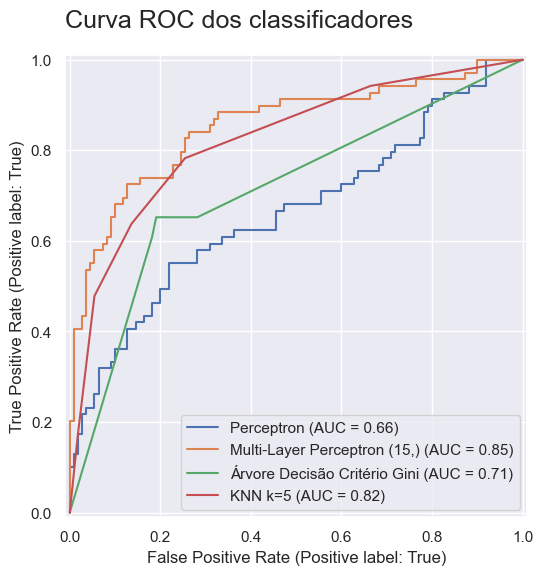

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay

classificadores = {
    "Perceptron": {"modelo": Perceptron(), "scores": []},
    "Multi-Layer Perceptron (15,)": {"modelo": MLPClassifier(random_state=1, hidden_layer_sizes=(15,), max_iter=2000),
                                     "scores": []},
    "Árvore Decisão Critério Gini": {"modelo": DecisionTreeClassifier(criterion='gini'), "scores": []},
    "KNN k=5": {"modelo": KNeighborsClassifier(n_neighbors=5), "scores": []}
}

_, ax = plt.subplots(figsize=(10, 6))

for classificador_name in classificadores:
    classificador = classificadores[classificador_name]["modelo"]
    classificador.fit(X_train, y_train)
    classificadores[classificador_name]["scores"].append(classificador.score(X_test, y_test))
    roc_display = RocCurveDisplay.from_estimator(classificador, X_test, y_test, ax=ax, name=classificador_name)

plt.title('Curva ROC dos classificadores', loc='left', pad=20, size=18)
plt.show()

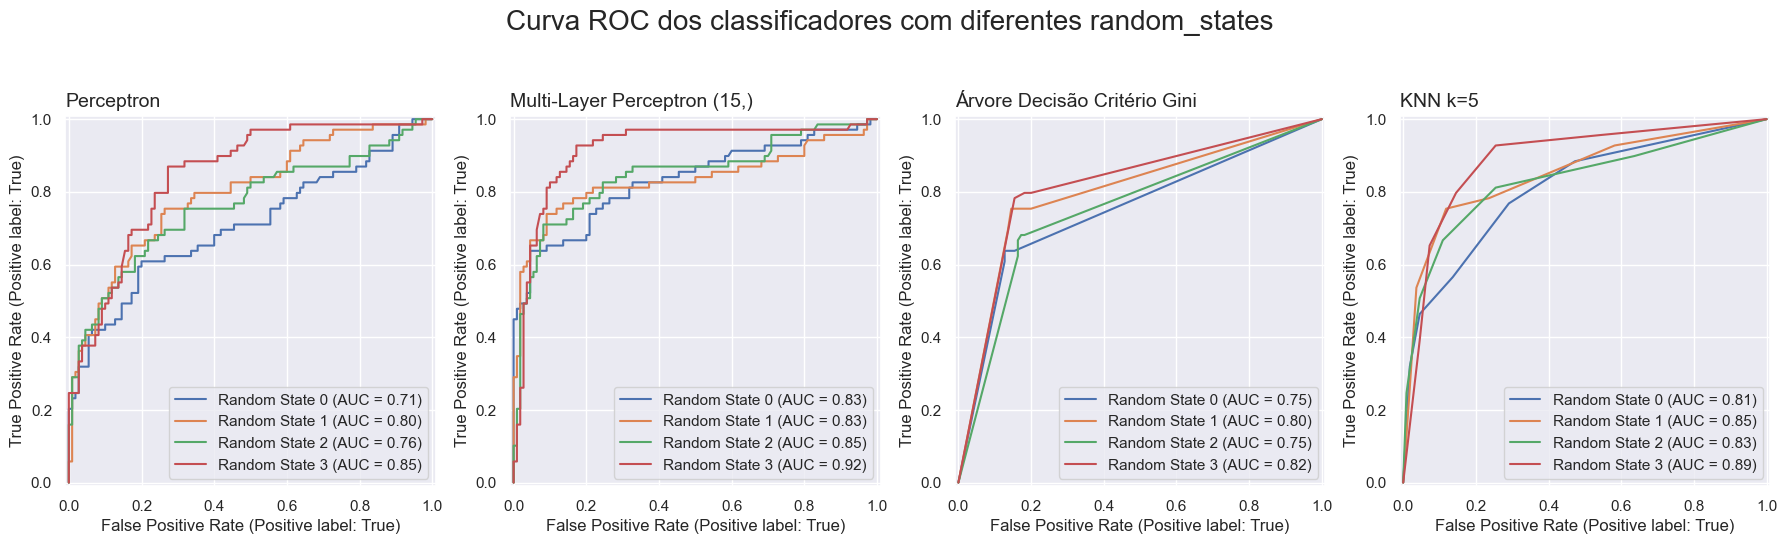

In [8]:
# Testando cada classifcador com 5 random_states diferentes (1 classificador por gráfico)
fig, ax = plt.subplots(ncols=4, figsize=(22, 6))
fig.suptitle('Curva ROC dos classificadores com diferentes random_states', size=20)
for i, classificador_name in enumerate(classificadores):
    for j in range(4):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=j, stratify=y)
        classificador = classificadores[classificador_name]["modelo"]
        classificador.fit(X_train, y_train)
        roc_display = RocCurveDisplay.from_estimator(
            classificador, X_test, y_test,
            ax=ax[i], name='Random State ' + str(j))
    ax[i].set_title(f'{classificador_name}', loc='left', size=14)

plt.show()

### Questão 03.

Implemente o 10-Fold Cross Validation (pode usar o scikit) com os dois melhores classificadores de acordo com a curva ROC e guarde a acurácia de cada fold na chave 'scores' do dicionário de classificadores.

In [9]:
# Seu código aqui
# Lembre-se do pré-processamento
from sklearn.model_selection import cross_val_score

for classificador_name in ["Multi-Layer Perceptron (15,)", "KNN k=5"]:
    classificador = classificadores[classificador_name]["modelo"]
    classificadores[classificador_name]['scores'] = cross_val_score(classificador, X, y, cv=10)
    print(f'{classificador_name}: {classificadores[classificador_name]["scores"].mean()}')

Multi-Layer Perceptron (15,): 0.8114606741573034
KNN k=5: 0.795792759051186


### Questão 04.
Altere a configuração da rede MLP, da arvore de Decisão (use outra função de entropia, o no. de vizinhos mais proximo no método KNN. Verifique o desempenho de cada um deles e compare com cada caso anterior.

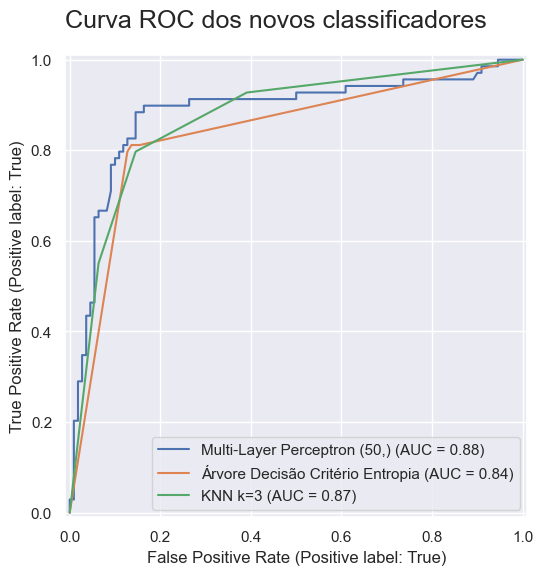

In [10]:
# Seu código aqui
novos_classificadores = {
    "Multi-Layer Perceptron (50,)": {"modelo": MLPClassifier(random_state=1, hidden_layer_sizes=(50,), max_iter=2000),
                                     "scores": []},
    "Árvore Decisão Critério Entropia": {"modelo": DecisionTreeClassifier(criterion='entropy'), "scores": []},
    "KNN k=3": {"modelo": KNeighborsClassifier(n_neighbors=3), "scores": []}
}

_, ax = plt.subplots(figsize=(10, 6))

for classificador_name in novos_classificadores:
    classificador = novos_classificadores[classificador_name]["modelo"]
    classificador.fit(X_train, y_train)
    novos_classificadores[classificador_name]["scores"].append(classificador.score(X_test, y_test))
    # Adicionando os scores para o cross-validation
    novos_classificadores[classificador_name]["scores"] = cross_val_score(classificador, X, y, cv=10)
    roc_display = RocCurveDisplay.from_estimator(classificador, X_test, y_test, ax=ax, name=classificador_name)

plt.title('Curva ROC dos novos classificadores', loc='left', pad=20, size=18)
plt.show()

In [11]:
# Comparando os dois scores
print('\nScores dos classificadores antigos:')
for classificador_name in classificadores:
    print(f'{classificador_name}: {np.mean(classificadores[classificador_name]["scores"]):.5f}')

print('\nScores dos novos classificadores:')
for classificador_name in novos_classificadores:
    print(f'{classificador_name}: {np.mean(novos_classificadores[classificador_name]["scores"]):.5f}')

print('\nOs modelos de MLP e Árvore de Decisão com critério de entropia apresentaram melhor desempenho.')


Scores dos classificadores antigos:
Perceptron: 0.68156
Multi-Layer Perceptron (15,): 0.81146
Árvore Decisão Critério Gini: 0.74860
KNN k=5: 0.79579

Scores dos novos classificadores:
Multi-Layer Perceptron (50,): 0.82049
Árvore Decisão Critério Entropia: 0.80135
KNN k=3: 0.78798

Os modelos de MLP e Árvore de Decisão com critério de entropia apresentaram melhor desempenho.


### Questão 05.

Verifique se há diferença estatística significante entre suas acurácias da questão anterior utilizando o teste T (`scipy.stats.ttest_ind`). Considere que há diferença significante se p <= 0.05 (rejeita-se a hipótese nula)

In [12]:
from itertools import combinations
from scipy.stats import ttest_ind
import warnings
# Ignore runtime warnings for the t-test
warnings.filterwarnings("ignore", category=RuntimeWarning)

all_classifiers = {**classificadores, **novos_classificadores}

for (name1, data1), (name2, data2) in combinations(all_classifiers.items(), 2):
    t_stat, p_value = ttest_ind(data1['scores'], data2['scores'])
    if p_value <= 0.05:
        print(f'{name1} x {name2}: p-value = {p_value:.5f}')
        print('Há diferença estatística significante entre as acurácias.\n')

Perceptron x Multi-Layer Perceptron (15,): p-value = 0.00179
Há diferença estatística significante entre as acurácias.

Perceptron x KNN k=5: p-value = 0.02685
Há diferença estatística significante entre as acurácias.

Perceptron x Multi-Layer Perceptron (50,): p-value = 0.00562
Há diferença estatística significante entre as acurácias.

Perceptron x Árvore Decisão Critério Entropia: p-value = 0.01520
Há diferença estatística significante entre as acurácias.

